# List of imports

In [31]:
from glob import glob
import pandas.core.common
from torch.utils.data import Dataset
import cv2
import numpy as np
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Creating lists of image paths
Creating train, valid and test sets. Train and valid sets are split 80/20.

In [32]:
train_data_path = 'data\\train'
test_data_path = 'data\\test'

classes, test_image_paths, train_image_paths  = [], [], []

for data_path in glob(train_data_path + '\\*'):
    classes.append(" ".join(" - ".join(data_path.split('\\')[-1].split('___')).split('_')))
    train_image_paths.append(glob(data_path + '\\*'))
    
train_image_paths = list(pandas.core.common.flatten(train_image_paths))

for data_path in glob(test_data_path + '\\*'):
    test_image_paths.append(glob(data_path + '\\*'))

test_image_paths = list(pandas.core.common.flatten(test_image_paths))

split_index = int(len(train_image_paths) * 0.8)
random.shuffle(train_image_paths)
train_image_paths, valid_image_paths = train_image_paths[:split_index], train_image_paths[split_index:]

print('class example: ', classes[0])
print('train_image_path example: ', train_image_paths[0])
print('test_image_path example: ', test_image_paths[0], end='\n\n')

print(f'Classes size: {len(classes)}', end='\n\n')
print(f'Train size: {len(train_image_paths)}')
print(f'Valid size: {len(valid_image_paths)}')
print(f'Test size: {len(test_image_paths)}')


class example:  Apple - healthy
train_image_path example:  data\train\Potato___late_blight\Healthy_496.jpg
test_image_path example:  data\test\Apple___healthy\1001.jpg.jpeg

Classes size: 20

Train size: 31779
Valid size: 7945
Test size: 1701


In [33]:
idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

### Map indexes to classes and classes to indexes

# Create Datasets

In [34]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)
        image = torch.tensor(image).permute(2, 0, 1)
        
        label = " ".join(" - ".join(image_path.split('\\')[-2].split('___')).split('_'))
        index = class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, index

transforms = T.Compose([
    T.Resize((256, 256))
])

train_dataset = PlantDataset(train_image_paths, transforms)
valid_dataset = PlantDataset(valid_image_paths, transforms)
test_dataset = PlantDataset(test_image_paths, transforms)

# Visualize Dataset

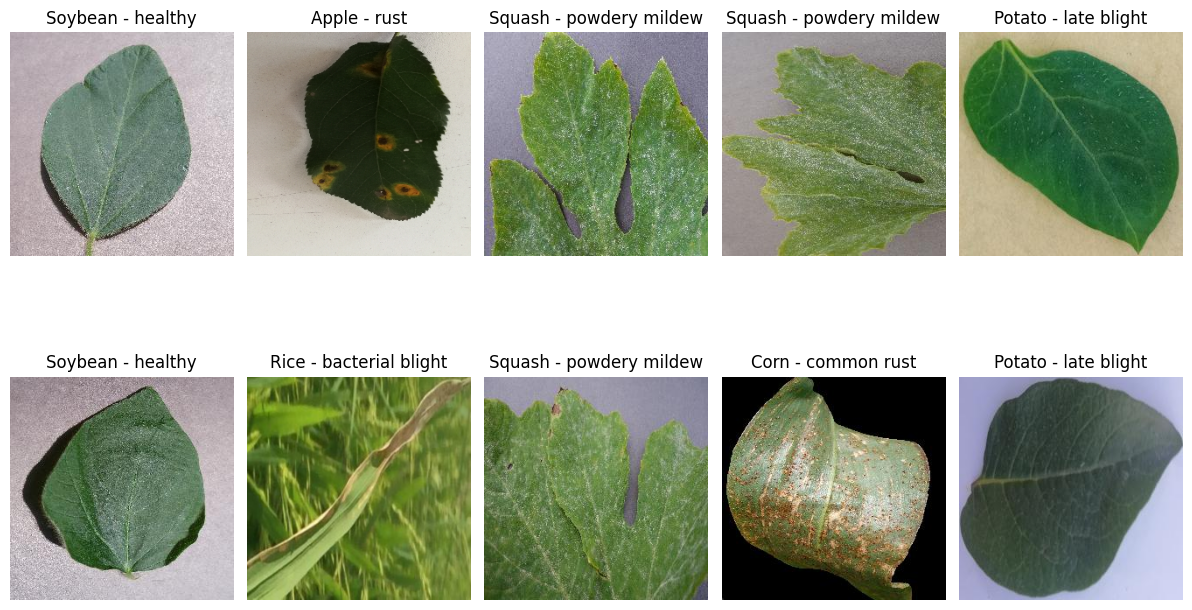

In [35]:
def visualize_augmentations(dataset, samples=10, cols=5):
    rows = samples // cols
    ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))[1]

    for i in range(samples):
        idx = np.random.randint(1,len(train_image_paths))
        image, index = dataset[idx]
        image = image.numpy().astype(np.uint8)
        
        ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[index])

    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset)

# Defining Dataloaders

In [36]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=32, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


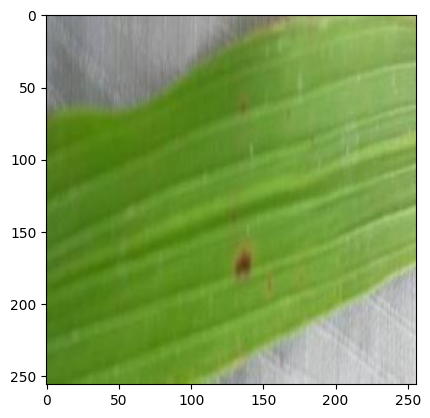

Label: Rice - brown spot


In [37]:
image, index = next(iter(train_loader))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {index.size()}")
image = image[0].numpy().astype(np.uint8)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
print(f"Label: {idx_to_class[index[0].item()]}")

In [38]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [39]:
def convBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class NeuralNetwork(nn.Module):
	
    def __init__(self):
        super().__init__()
        
        self.conv1 = convBlock(3, 64)
        self.conv2 = convBlock(64, 128, pool=True) 
        self.res1 = nn.Sequential(convBlock(128, 128), convBlock(128, 128))
        
        self.conv3 = convBlock(128, 256, pool=True)
        self.conv4 = convBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(convBlock(512, 512), convBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                         nn.Flatten(),
                                         nn.Linear(512, len(classes)))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.classifier(out)
        return out

In [40]:
net = NeuralNetwork().to(device)
print(net)

NeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=1e-3)

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start.record()

for epoch in range(10):

    train_loss = 0.0
    train_correct = 0 
    train_total = 0
    net.train()
    for i, train_data in enumerate(train_loader, 0):

        train_inputs, train_labels = train_data
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        optimizer.zero_grad()
        outputs = net(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == train_labels).sum().item()
    
    train_loss_avg = train_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    print(f'[{epoch + 1}, {i + 1}] Train loss: {train_loss_avg:.3f}')
    print(f'[{epoch + 1}, {i + 1}] Train acc: {train_acc:.3f}')
    
    valid_loss = 0.0
    valid_correct = 0 
    valid_total = 0
    net.eval()
    with torch.no_grad():
        for i, valid_data in enumerate(valid_loader, 0):
            valid_inputs, valid_labels = valid_data
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            
            valid_outputs = net(valid_inputs)
            loss = criterion(valid_outputs, valid_labels)
            valid_loss += loss.item()

            _, predicted = torch.max(valid_outputs.data, 1)
            valid_correct += (predicted == valid_labels).sum().item() 

    valid_loss_avg = valid_loss / len(valid_loader)
    valid_acc = valid_correct / len(valid_loader.dataset)
    print(f'Epoch {epoch + 1} Valid loss: {valid_loss_avg:.3f}')
    print(f'Epoch {epoch + 1} Valid acc: {valid_acc:.2%}')

    train_losses.append(train_loss_avg) 
    train_accs.append(train_acc)
    val_losses.append(valid_loss_avg)
    val_accs.append(valid_acc)

end.record()
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

In [ ]:
torch.save(net.state_dict(), "./models/model2.pth")

In [ ]:
net.load_state_dict(torch.load("./models/model2.pth"))
net.eval()
net.to(device)

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = "Train Loss", c = "red")
plt.plot(val_losses, label = "Validation Loss", c = "blue")
plt.xlabel("Epochs"); plt.ylabel("Loss Values")
plt.xticks(ticks = np.arange(len(train_losses)), labels = [i for i in range(1, len(train_losses) + 1)])
plt.legend(); plt.show()

plt.figure(figsize = (10, 5))
plt.plot(train_accs, label = "Train Accuracy", c = "orangered")
plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
plt.xticks(ticks = np.arange(len(train_accs)), labels = [i for i in range(1, len(train_accs) + 1)])
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

print(f'Accuracy of the network on the test images: {(correct / total):.2%}')

In [ ]:
def get_preds_and_actual(model, loader):
    predictions = torch.tensor([]).to(device)
    actuals = torch.tensor([]).to(device)
    for batch in loader:
        images, actual = batch
        images, actual = images.to(device), actual.to(device)

        pred = model(images)
        predictions = torch.cat((predictions, pred),dim=0)
        actuals = torch.cat((actuals, actual),dim=0)

    return predictions.argmax(dim=1).int(), actuals.int()

In [ ]:
def get_correct(predictions, actuals):
    result = 0
    for i in range(len(predictions)):
        if predictions[i] == actuals[i]:
            result += 1
    return result

In [ ]:
with torch.no_grad():
    predictions, actuals = get_preds_and_actual(net, train_loader), get_correct(net, train_loader)

In [ ]:
correct = get_correct(predictions, actuals)
print(f'Accuracy of the network on the train images: {(correct / len(actuals)):.2%}')

In [ ]:
cm = confusion_matrix(actuals.cpu(), predictions.cpu())

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix with improved readability
fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')  # Change color map and rotate x-axis labels
plt.xticks(fontsize=10)  # Increase x-axis font size
plt.yticks(fontsize=10)  # Increase y-axis font size
plt.grid(False)  # Add grid for better separation

# Display the plot
plt.show()